# Semi-supervised VAE m2

This model is based on Kinga et al [paper](https://arxiv.org/abs/1406.5298).
Implementation follow pyro tutorial, which can be found [here](https://pyro.ai/examples/ss-vae.html).

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
from pathlib import Path

import numpy as np
import pyro
import torch
from imblearn.over_sampling import SMOTE
from pyro.infer import (SVI, JitTrace_ELBO, JitTraceEnum_ELBO, Trace_ELBO,
                        TraceEnum_ELBO, config_enumerate)
from pyro.optim import Adam
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

from util.plot import Plot
from vae.ss_vae import SSVAE
from vae.trainer import Trainer

## Parameters

In [11]:
SEED = 42
Z_DIM = 48  # size of the tensor representing the latent variable z
HIDDEN_LAYERS = [192]  # a tuple (or list) of MLP layers to be used in the neural networks representing the parameters of the distributions in our model
ENUM_DISCRETE = 'parallel'  # parallel, sequential or none. uses parallel enumeration by default

AUX_LOSS = True  # whether to use the auxiliary loss from NIPS 14 paper (Kingma et al)
AUX_LOSS_MULTIPLIER = 46  # the multiplier to use with the auxiliary loss

LEARNING_RATE = 0.001
BETA_1 = 0.9
USE_JIT = False  # use PyTorch jit to speed up training

BATCH_SIZE = 100
NUM_EPOCHS = 50

SUP_TRAIN_PATH = Path('../data/wust-train-sentence-embeddigs.pickle')
SUP_TEST_PATH = Path('../data/wust-test-sentence-embeddigs.pickle')
UNSUP_PATH = Path('../data/unsup_small_embeddings.pickle')
OUTPUT_MODEL_PATH = Path('ss_vae_m2.pth')

## Loading data

In [3]:
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)

with SUP_TRAIN_PATH.open('rb') as file:
    sup_train = pickle.load(file)

with SUP_TEST_PATH.open('rb') as file:
    sup_test = pickle.load(file)

with UNSUP_PATH.open('rb') as file:
    unsup = pickle.load(file)
    unsup_x = unsup['sentence_embeddings']
    unsup_x = torch.FloatTensor(unsup_x).to(device)

sup_train_labels = np.array(sup_train['labels']).reshape(-1, 1)
sup_test_labels = np.array(sup_test['labels']).reshape(-1, 1)

sup_train_x = sup_train['sentence_embeddings']
smote = SMOTE(random_state=SEED)
sup_train_x, sup_train_labels = smote.fit_resample(
    sup_train_x,
    sup_train_labels
)
sup_train_labels = sup_train_labels.reshape(-1, 1)

sup_train_x = torch.FloatTensor(sup_train_x).to(device)
sup_test_x = torch.FloatTensor(sup_test['sentence_embeddings']).to(device)

encoder = OneHotEncoder()
encoder.fit(sup_train_labels)

sup_train_y = encoder.transform(sup_train_labels)
sup_test_y = encoder.transform(sup_test_labels)
sup_train_y = torch.LongTensor(sup_train_y.toarray()).to(device)
sup_test_y = torch.LongTensor(sup_test_y.toarray()).to(device)

sup_train_ds = TensorDataset(sup_train_x, sup_train_y)
sup_train_dl = DataLoader(
    sup_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

unsup_train_ds = TensorDataset(unsup_x)
unsup_train_dl = DataLoader(
    unsup_train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True
)

## Setting up the model

In [4]:
pyro.set_rng_seed(SEED)

ss_vae = SSVAE(
    input_size=sup_train_x.shape[1],
    output_size=sup_train_y.shape[1],
    z_dim=Z_DIM,
    hidden_layers=HIDDEN_LAYERS,
    use_cuda=torch.cuda.is_available(),
    config_enum=ENUM_DISCRETE,
    aux_loss_multiplier=AUX_LOSS_MULTIPLIER
)

optimizer = Adam({"lr": LEARNING_RATE, "betas": (BETA_1, 0.999)})

# set up the loss(es) for inference. wrapping the guide in config_enumerate builds the loss as a sum
# by enumerating each class label for the sampled discrete categorical distribution in the model
guide = config_enumerate(ss_vae.guide, ENUM_DISCRETE, expand=True)
Elbo = JitTraceEnum_ELBO if USE_JIT else TraceEnum_ELBO
elbo = Elbo(max_plate_nesting=1, strict_enumeration_warning=False)
loss_basic = SVI(ss_vae.model, guide, optimizer, loss=elbo)

# build a list of all losses considered
losses = [loss_basic]

# aux_loss: whether to use the auxiliary loss from NIPS 14 paper (Kingma et al)
if AUX_LOSS:
    elbo = JitTrace_ELBO() if USE_JIT else Trace_ELBO()
    loss_aux = SVI(ss_vae.model_classify, ss_vae.guide_classify, optimizer, loss=elbo)
    losses.append(loss_aux)

## Fitting the model

In [5]:
trainer = Trainer()
fit_stats = trainer.fit(
    epochs=NUM_EPOCHS,
    sup_train_data_loader=sup_train_dl,
    unsup_train_data_loader=unsup_train_dl,
    losses=losses,
    sup_test_x=sup_test_x,
    sup_test_y=sup_test_y,
    ss_vae=ss_vae,
    encoder=encoder,
    verbose=1
)

Epochs: 100%|██████████| 50/50 [10:58<00:00, 13.17s/it]49 epoch: loss sup: -1737.0312 loss unsup: -1740.3499 loss aux sup: 0.9932 aux unsup: 0.0000



## Model Convergence

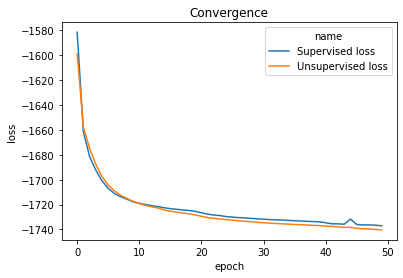

In [6]:
plot = Plot()
plot.convergence(
    [fit_stats.sup_loss_history, fit_stats.unsup_loss_history],
    ['Supervised loss', 'Unsupervised loss']
)

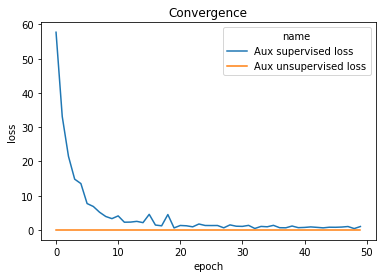

In [7]:
plot.convergence(
    [fit_stats.aux_sup_loss_history, fit_stats.aux_unsup_loss_history],
    ['Aux supervised loss', 'Aux unsupervised loss']
)

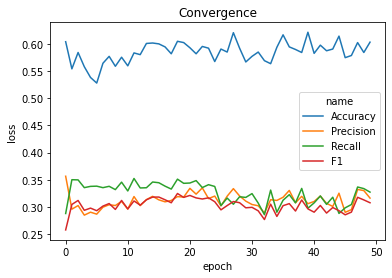

In [8]:
acc_history = [metric.accuracy for metric in fit_stats.test_metric_history]
prec_history = [metric.precision for metric in fit_stats.test_metric_history]
recall_history = [metric.recall for metric in fit_stats.test_metric_history]
f1_history = [metric.f1 for metric in fit_stats.test_metric_history]

plot.convergence(
    [acc_history, prec_history, recall_history, f1_history],
    ['Accuracy', 'Precision', 'Recall', 'F1']
)

## Results

In [9]:
y_pred = ss_vae.classifier(sup_test_x)
y_pred = encoder.inverse_transform(y_pred.cpu().numpy())
y_test = encoder.inverse_transform(sup_test_y.cpu().numpy())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   neutralne       0.85      0.73      0.79       777
 oczekiwanie       0.03      0.02      0.03        42
      podziw       0.59      0.35      0.44        77
      radosc       0.41      0.49      0.45       124
      smutek       0.25      0.16      0.20        31
      strach       0.05      0.15      0.08        20
      wstret       0.09      0.14      0.11        35
 zaskoczenie       0.09      0.26      0.14        19
       zlosc       0.48      0.63      0.55       139

    accuracy                           0.60      1264
   macro avg       0.32      0.33      0.31      1264
weighted avg       0.66      0.60      0.63      1264



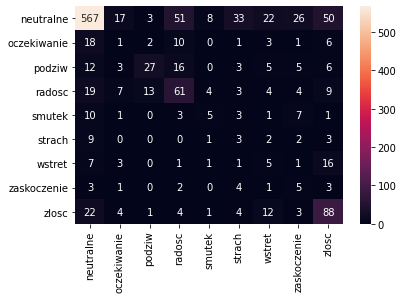

In [10]:
plot.confusion_matrix(y_test, y_pred)

In [12]:
model = ss_vae.encoder_y.eval().cpu()
torch.save(ss_vae.encoder_y, str(OUTPUT_MODEL_PATH))